# Building Skin cancer classification using transfer learning 
# (Inception V3)

## Article reference

- https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6&fbclid=IwAR3ySc4WozYU5qyZ6wU43PIzv2JioHtyHBnnr79fLagdP74sp7BOf_j-ynw


In [1]:
# Basic library
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import itertools
import time

# Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight # For class imbalancing
from sklearn.model_selection import train_test_split

import keras
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.preprocessing import image

# Import google inception v3 as pre-trained model for transfer learning
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# keras layer utilities
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, GlobalMaxPooling2D
from keras.layers import Input
from keras.models import Model
from keras import optimizers
from keras.regularizers import l2

from keras.callbacks import TensorBoard
from keras.models import load_model


import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14519677774397083402
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1500636774
locality {
  bus_id: 1
}
incarnation: 15656117348654121559
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


##### Data preparation

In [85]:
base_skin_dir = r'.input'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

base_skin_dir = os.path.join('input')

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes



In [86]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


In [87]:
# Step 4 : Data Cleaning
# In this step we check for Missing values and datatype of each field
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [89]:
# As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [90]:
#skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((299,299))))

features=skin_df.drop('cell_type_idx',axis=1)
target=skin_df['cell_type_idx']

In [91]:
skin_df[['dx', 'cell_type_idx']].drop_duplicates(inplace=False)

,dx,cell_type_idx
0,bkl,2
64,nv,4
1095,df,3
1211,mel,5
2320,vasc,6
2462,bcc,1
9687,akiec,0


In [5]:
# Train test split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
        features, target, test_size=0.20,random_state=1234)

##### Split images for usage in flow_from_directory 

In [10]:
# Split images for usage in flow_from_directory 
import shutil
from time import time

def images_mover(base_path, classes_list, images_path, images_class):
    ''' create directories for the usage of keras flow_from_directory
    Args
    ====
    base_path : 
    classes_list : (list) classes of current training data, folders will be created for each classes
    images_path : (series) series that contains the path of all images
    images_class : (series) series that contains the corresponding class for each images in images_path
    
    Returns
    =======
    None
    
    '''
    for cl in classes_list:
        os.mkdir(f'{base_path}/{cl}')
    
    t = time()
    for idx,file in enumerate(images_path):
        #print(file)
        cl = images_class.iloc[idx]
        new_dir = f'{base_path}/{cl}'
        shutil.copy(file, new_dir)
        #print(file+" move to "+ new_dir)
        
    print("Done with moving in %fs"%(time()-t))

os.mkdir('input/training')
os.mkdir('input/testing')

images_mover(base_path='input/training', classes_list=skin_df['cell_type_idx'].unique(),
             images_path=x_train_o['path'], images_class=y_train_o)

Done with moving in 104.954081s


In [11]:
images_mover(base_path='input/testing', classes_list=skin_df['cell_type_idx'].unique(),
             images_path=x_test_o['path'], images_class=y_test_o)

Done with moving in 26.417501s


## EDA

In [13]:
skin_df.groupby('cell_type_idx').agg({"path":'count'})

,path
cell_type_idx,
0,327
1,514
2,1099
3,115
4,6705
5,1113
6,142


4th class have the most examples

In [14]:
skin_df.shape

(10015, 10)

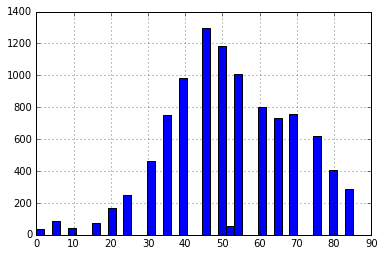

In [93]:
skin_df['age'].hist(bins=40)

=> Larger instances of patients having age from 30 to 60.

## Building keras model

Ref:
https://github.com/hoang-ho/Skin_Lesions_Classification_DCNNs/blob/master/Fine_Tuning_InceptionV3.ipynb

In [2]:
''' 
Image Augmentation --> instantiate generators of augmented image batches

I followed the pre-processing technique from nature article, i.e. random rotation and random vertical flip.
''' 

# image augmentation for training set
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         rotation_range = 359,
                                         vertical_flip=True) # randomly flip images

# image augmentation for validation set
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [3]:
training_batch_size = 8
validation_batch_size = 8

train_generator = train_datagen.flow_from_directory(
        r'input\training',
        target_size = (299, 299),
        batch_size = training_batch_size,
        class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
        r'input\testing',
        target_size = (299, 299),
        batch_size = validation_batch_size,
        class_mode = 'categorical')

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [4]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [6]:

for layer in base_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(base_model.layers))

input_2
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
conv2d_97
batch_normalization_97
activation_97
max_pooling2d_5
conv2d_98
batch_normalization_98
activation_98
conv2d_99
batch_normalization_99
activation_99
max_pooling2d_6
conv2d_103
batch_normalization_103
activation_103
conv2d_101
conv2d_104
batch_normalization_101
batch_normalization_104
activation_101
activation_104
average_pooling2d_10
conv2d_100
conv2d_102
conv2d_105
conv2d_106
batch_normalization_100
batch_normalization_102
batch_normalization_105
batch_normalization_106
activation_100
activation_102
activation_105
activation_106
mixed0
conv2d_110
batch_normalization_110
activation_110
conv2d_108
conv2d_111
batch_normalization_108
batch_normalization_111
activation_108
activation_111
average_pooling2d_11
conv2d_107
conv2d_109
conv2d_112
conv2d_113
batch_normalization_107
batch_normalization_109
batch_normalization_112
batch_normalization_113
activation_107
activation_109
activa

In [5]:
last_layer = base_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, None, None, 2048)


In [11]:
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(base_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [7]:
# Custom mertrics to calculate f1-score, recall, and precision after each epoch
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        test_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
        predictions = self.model.predict_generator(validation_generator, steps=test_steps_per_epoch)
        # Get most likely class
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = validation_generator.classes
        class_labels = list(validation_generator.class_indices.keys())   

        #report = metrics.f1_score(true_classes, predicted_classes)
        precisions, recall, f1_score, _ = metrics.precision_recall_fscore_support(
                                            true_classes, predicted_classes)
        _val_f1 = np.mean(f1_score)
        _val_recall = np.mean(recall)
        _val_precision = np.mean(precisions)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

# Create an instant
metric = Metrics()

In [13]:
epochs = 3

history = model.fit_generator(train_generator,
                              epochs = epochs, 
                              validation_data = validation_generator,
                              verbose = 1, 
                              steps_per_epoch = tra
                              in_generator.samples // training_batch_size,
                              validation_steps = validation_generator.samples // validation_batch_size,
                              #class_weight=class_weight,
                              callbacks=[metric]                         
                             )

Epoch 1/3
1001/1001 [==============================] - 11129s 11s/step - loss: 1.3399 - acc: 0.6359 - val_loss: 1.0636 - val_acc: 0.6620
— val_f1: 0.114560 — val_precision: 0.101040 — val_recall 0.140886
Epoch 2/3
1001/1001 [==============================] - 3012s 3s/step - loss: 1.0710 - acc: 0.6675 - val_loss: 0.9908 - val_acc: 0.6637
— val_f1: 0.114403 — val_precision: 0.105150 — val_recall 0.142521
Epoch 3/3
1001/1001 [==============================] - 4460s 4s/step - loss: 1.0243 - acc: 0.6697 - val_loss: 0.9692 - val_acc: 0.6612
— val_f1: 0.117462 — val_precision: 0.108139 — val_recall 0.141717


In [14]:
model.save(r'model\modelV2_first_3_epo.h5')

In [8]:
model = load_model(r'model\modelV2_first_3_epo.h5')

In [9]:
for layer in base_model.layers[249:]:
    layer.trainable = True

In [10]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [12]:
batch_size = 8
epochs = 5
history = model.fit_generator(train_generator,
                              epochs = epochs, 
                              validation_data = validation_generator,
                              verbose = 1, 
                              steps_per_epoch=train_generator.samples // training_batch_size,
                              validation_steps=validation_generator.samples // validation_batch_size,
                              callbacks=[metric, learning_rate_reduction])

Epoch 1/5
1001/1001 [==============================] - 3002s 3s/step - loss: 1.0145 - acc: 0.6686 - val_loss: 0.9207 - val_acc: 0.6795
— val_f1: 0.127131 — val_precision: 0.131175 — val_recall 0.140755
Epoch 2/5
1001/1001 [==============================] - 2916s 3s/step - loss: 0.9748 - acc: 0.6802 - val_loss: 0.8995 - val_acc: 0.6782
— val_f1: 0.126912 — val_precision: 0.113783 — val_recall 0.145922
Epoch 3/5
1001/1001 [==============================] - 2918s 3s/step - loss: 0.9583 - acc: 0.6782 - val_loss: 0.8823 - val_acc: 0.6762
— val_f1: 0.123738 — val_precision: 0.111917 — val_recall 0.143850
Epoch 4/5
1001/1001 [==============================] - 2919s 3s/step - loss: 0.9328 - acc: 0.6888 - val_loss: 0.8728 - val_acc: 0.6827
— val_f1: 0.121158 — val_precision: 0.109101 — val_recall 0.141504
Epoch 5/5
1001/1001 [==============================] - 2796s 3s/step - loss: 0.9350 - acc: 0.6823 - val_loss: 0.8748 - val_acc: 0.6862
— val_f1: 0.126880 — val_precision: 0.117224 — val_recall

In [13]:
model.save(r'model\modelV2_3_5_epo.h5')

In [14]:
model = load_model(r'model\modelV2_3_5_epo.h5')

In [15]:
# Train model for 5 more epochs
batch_size = 8
epochs = 5
history = model.fit_generator(train_generator,
                              epochs = epochs, 
                              validation_data = validation_generator,
                              verbose = 1, 
                              steps_per_epoch=train_generator.samples // training_batch_size,
                              validation_steps=validation_generator.samples // validation_batch_size,
                              callbacks=[metric, learning_rate_reduction])

Epoch 1/5
1001/1001 [==============================] - 1706s 2s/step - loss: 0.9320 - acc: 0.6838 - val_loss: 0.8550 - val_acc: 0.6765
— val_f1: 0.124408 — val_precision: 0.114059 — val_recall 0.144608
Epoch 2/5
1001/1001 [==============================] - 2330s 2s/step - loss: 0.9056 - acc: 0.6881 - val_loss: 0.8587 - val_acc: 0.6807
— val_f1: 0.123616 — val_precision: 0.111708 — val_recall 0.143298
Epoch 3/5
1001/1001 [==============================] - 1641s 2s/step - loss: 0.9001 - acc: 0.6906 - val_loss: 0.8183 - val_acc: 0.6957
— val_f1: 0.124427 — val_precision: 0.124245 — val_recall 0.141717
Epoch 4/5
1001/1001 [==============================] - 1933s 2s/step - loss: 0.8785 - acc: 0.6978 - val_loss: 0.8041 - val_acc: 0.7063
— val_f1: 0.119032 — val_precision: 0.107950 — val_recall 0.134049
Epoch 5/5
1001/1001 [==============================] - 2580s 3s/step - loss: 0.8792 - acc: 0.6968 - val_loss: 0.8004 - val_acc: 0.7043
— val_f1: 0.136866 — val_precision: 0.151074 — val_recall

In [16]:
# Train model on another 5 more epochs, in total 13 epochs.
batch_size = 8
epochs = 5
history = model.fit_generator(train_generator,
                              epochs = epochs, 
                              validation_data = validation_generator,
                              verbose = 1, 
                              steps_per_epoch=train_generator.samples // training_batch_size,
                              validation_steps=validation_generator.samples // validation_batch_size,
                              callbacks=[metric, learning_rate_reduction])

Epoch 1/5
1001/1001 [==============================] - 1440s 1s/step - loss: 0.8678 - acc: 0.6993 - val_loss: 0.7875 - val_acc: 0.7060
— val_f1: 0.120742 — val_precision: 0.121300 — val_recall 0.133153
Epoch 2/5
1001/1001 [==============================] - 1238s 1s/step - loss: 0.8492 - acc: 0.6996 - val_loss: 0.7822 - val_acc: 0.7058
— val_f1: 0.123404 — val_precision: 0.112520 — val_recall 0.139313
Epoch 3/5
1001/1001 [==============================] - 1218s 1s/step - loss: 0.8468 - acc: 0.7057 - val_loss: 0.7799 - val_acc: 0.7098
— val_f1: 0.128372 — val_precision: 0.119163 — val_recall 0.143878
Epoch 4/5
1001/1001 [==============================] - 2181s 2s/step - loss: 0.8467 - acc: 0.7019 - val_loss: 0.7718 - val_acc: 0.7048
— val_f1: 0.129906 — val_precision: 0.120689 — val_recall 0.145849
Epoch 5/5
1001/1001 [==============================] - 1673s 2s/step - loss: 0.8262 - acc: 0.7069 - val_loss: 0.7796 - val_acc: 0.7218
— val_f1: 0.128051 — val_precision: 0.125481 — val_recall

In [94]:
model.save(r'model\modelV2_3_10_epo.h5')

## Evaluation on the model

In [22]:
# Evaluate model by data generator
(loss, accuracy) = model.evaluate_generator(validation_generator)

In [26]:
print("[INFO] loss={:.5f}, accuracy: {:.5f}%".format(loss,accuracy * 100))

[INFO] loss=0.78287, accuracy: 71.94209%


In [37]:
# Get predicted and true classes.
predictions = model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45) # Do not show class name in x-axis
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[   0    1   10    0   48    1    0]
 [   0    6   13    0   76    2    0]
 [   0   11   20    0  190    2    1]
 [   0    3    3    0   21    0    0]
 [   0   59  211    0 1029   18    3]
 [   0   15   37    0  188    5    1]
 [   0    4    6    0   18    1    0]]


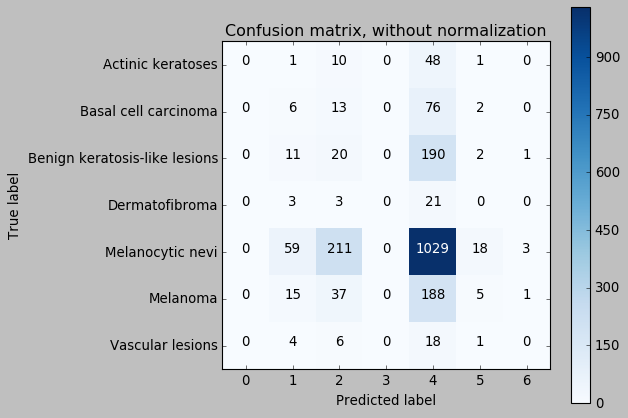

In [68]:
# Refer this link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
confusion_mat = confusion_matrix(true_classes, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(confusion_mat, 
                      classes=['Actinic keratoses','Basal cell carcinoma','Benign keratosis-like lesions',
                                'Dermatofibroma','Melanocytic nevi','Melanoma', 'Vascular lesions'],
                      title='Confusion matrix, without normalization')

plt.show()


=> Even though the accuracy seems quite good, but from the confusion matrix we can see that none instances of class **Artinic keratoses** and **Dermatofibroma** have been predicted correctly. Which can be suggested by the **low value of f1 score** (around **0.128**). Hence, accuracy is really **NOT** a good indicator in this problem. It is suspected that, the highly imbalaced dataset that made the classfier fail to learn the features of the class with extremely low training example. I should consider another way that could improve the f1 score, for example, solving the class imbalancing issue (by adjusting the weight of each class or resample the dataset before putting them into training).

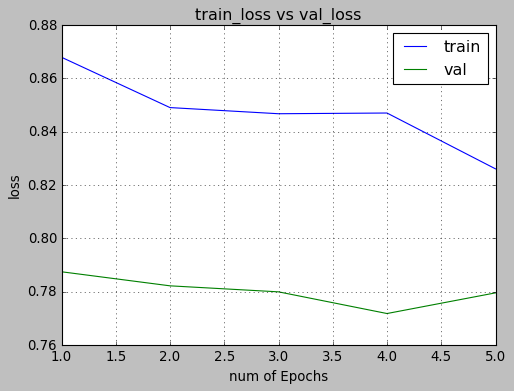

In [34]:
# visualizing losses for the last five epochs
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(1,6)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])
plt.show()



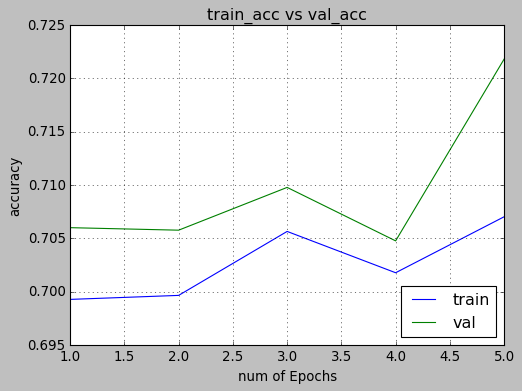

In [35]:
# visualizing accuracy for the last five epochs

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

-------------------------------------END